# HJ reachability basics

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np

from IPython.display import HTML
import matplotlib.animation as anim
import matplotlib.pyplot as plt



In [ ]:
!pip install tqdm

In [ ]:
!pip install hj_reachability
import hj_reachability as hj

### Example system: `Air3D`

In [2]:
dynamics = hj.systems.Air3d()
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(np.array([-6., -10., 0.]),
                                                                           np.array([20., 10., 2 * np.pi])),
                                                               (51, 40, 50),
                                                               periodic_dims=2)
values = jnp.linalg.norm(grid.states[..., :2], axis=-1) - 5

solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)

### `hj.step`: propagate the HJ PDE from `(time, values)` to `target_time`.

In [3]:
time = 0.
target_time = -2.8
target_values = hj.step(solver_settings, dynamics, grid, time, values, target_time)

100%|##########|  2.8000/2.799999952316284 [00:02<00:00,  1.22sim_s/s]


<Figure size 640x480 with 0 Axes>

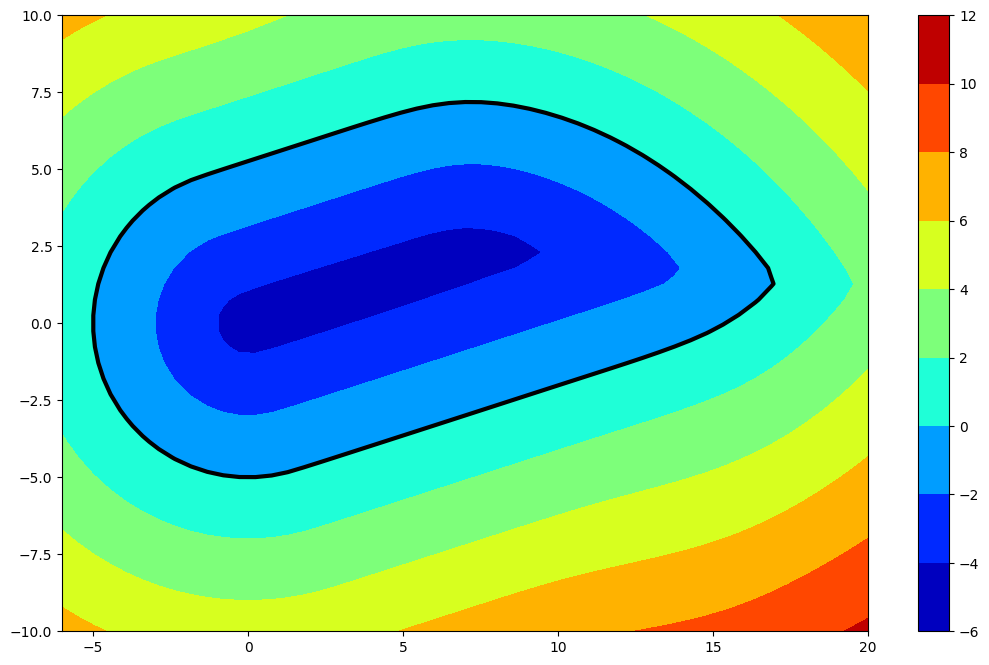

In [4]:
plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[:, :, 30].T)
plt.colorbar()
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            target_values[:, :, 30].T,
            levels=0,
            colors="black",
            linewidths=3)

### Value evaluation

In [15]:
state = grid.states[4,5,4] # define a state to evaluate the value function at

# use grid.interpolate to evaluate the value function at an interpolated state
V_value = grid.interpolate(target_values, state) # should == target_values[4,5,4]
V_value


Array(2.681387, dtype=float32)

### Gradient of value function evaluation

In [16]:
# perform central differencing over target_values
dV_values =  grid.grad_values(target_values)

In [17]:
dV_values.shape # shape is  [grid_size x state_dim]

(51, 40, 50, 3)

In [18]:
# use grid.interpolate to evaluate the gradient of value function at an interpolated state
grad_value = grid.interpolate(dV_values, state) # should == dV_values[4,5,4]
grad_value

Array([-0.57325363, -0.72994334, -0.39053124], dtype=float32)

### Compute optimal policy

In [22]:
state = grid.states[4,5,4] # define a state to evaluate policy at

# optimal_control_and_disturbance(self, state, time, grad_value)
a_opt, b_opt = dynamics.optimal_control_and_disturbance(state, 0., grad_value)
a_opt, b_opt

(Array([1.], dtype=float32), Array([1.], dtype=float32))